# Natural Language Processing --- a glimpse into theory and practice

This notebook shows how to extract information from text documents with the deep learning framework **[tensorflow](https://www.tensorflow.org')** and its high-level API **[keras](https://www.tensorflow.org/api_docs/python/tf/keras)**. Our task will be **named entity recognition (NER)** on legal texts and we will go through all of the necessary steps:

- **prepare** the data,
- **build** a bi-LSTM model,
- **train** and
- **evaluate** the model.


## Fun with word embeddings

We shall encode text as a sequence of word vectors, using the word embeddings provided by the NLP library [spaCy](https://spacy.io):

In [4]:
import spacy

nlp = spacy.load('en_core_web_md')
vocab = nlp.vocab

The word embeddings can now be accessed as follows:

In [5]:
vocab.get_vector('fun')

array([ 1.4147e-01,  1.7264e-01, -3.5865e-01, -4.5490e-01,  2.6629e-01,
        1.9800e-01,  1.1048e-01,  2.8269e-02,  3.4253e-01,  1.8359e+00,
       -5.6326e-01, -4.4621e-01,  2.7219e-02,  2.3749e-01,  2.5605e-02,
       -4.0058e-01, -3.0532e-01,  8.1734e-01, -5.2661e-01,  3.9568e-02,
        4.9383e-02, -8.7267e-02,  2.5790e-01, -1.3237e-01,  4.3894e-01,
        5.6373e-01,  6.4652e-01, -4.6927e-02,  1.9994e-01, -4.6308e-01,
       -5.2285e-02, -3.9085e-01, -1.1236e-01,  1.9775e-01,  4.8632e-01,
       -2.7640e-01,  2.6675e-01,  3.2560e-01, -7.0285e-02,  3.5359e-02,
       -6.7320e-03,  3.2060e-01, -1.0462e-01, -1.6121e-01,  4.2248e-02,
        5.5931e-01, -2.2568e-01,  3.8240e-02,  5.2018e-01, -2.9203e-01,
       -1.1388e-01,  3.2131e-01,  5.7159e-01,  1.4833e-02, -1.7957e-01,
        3.4490e-01, -6.3636e-02, -1.2622e-01, -7.2219e-02,  1.8993e-01,
        3.0634e-01,  9.7579e-02, -2.0734e-01, -5.3802e-02,  3.2095e-01,
       -3.0530e-01, -2.8957e-01,  3.7886e-01,  9.1884e-02,  7.92

With these word embeddings, we can already teach the computer to play little games like "Find the odd one out". Here, the task is to single out one word from a list that doesn't fit well with the others.

We solve this task as follows:

1. collect the word vector for each word and write it as a row into a matrix `vectors`,
2. compute the pairwise similarity of the word vectors in form of their dot product, which can be achieved by multiplying the matrix `vectors` by its transpose,
3. sum the similarities for each word, that is, along each row,
4. pick the word with the lowest sum of similarities.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

def find_the_odd_one(*samples):
    vectors = np.array([vocab.get_vector(s) for s in samples])
    sim = np.matmul(vectors, vectors.transpose())
    df = pd.DataFrame(sim, index=samples, columns=samples)
    sns.heatmap(df)
    sums = np.sum(sim, axis=1) - np.diagonal(sim)
    return samples[np.argmin(sums)]
                       
find_the_odd_one('mother', 'father', 'daughter', 'son', 'dog')

NameError: name 'vocab' is not defined

This works quite well:

'computer'

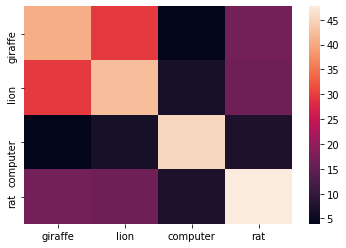

In [9]:
find_the_odd_one('giraffe', 'lion', 'computer', 'rat')

## Our dataset and task: named entity recognition in legal texts

Let us now consider a real-life NLP task. We use a dataset of legal texts presented by E. Leitner, G. Rehm and J. Moreno-Schneider  in
>
> **[Fine-grained Named Entity Recognition in Legal Documents.](https://link.springer.com/chapter/10.1007/978-3-030-33220-4_20)**.

It consists of **court decisions** from several German federal courts with annotations of entities referring to 

- legal norms, 
- court decisions, 
- legal litarature 
- and others 

of the following form:

<img src="img/legal_ner.png" width="75%" align="center">

The dataset is hosted on [github](https://github.com/elenanereiss/Legal-Entity-Recognition) and contained in one  [zip file](https://github.com/elenanereiss/Legal-Entity-Recognition/blob/master/../data/dataset_courts.zip) which we download and unzip:

In [3]:
!mkdir -p data
![ -f data/raw.zip ] || curl https://github.com/elenanereiss/Legal-Entity-Recognition/raw/master/data/dataset_courts.zip -L -o data/raw.zip
!unzip -n data/raw.zip -d data

Archive:  ../data/01_raw/raw.zip


Each file contains sentences of decisions issued by one court. 
 
The sentences come as paragraphs separated by blank lines, with one token and annotation in [BIO format](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)) per line as follows:

In [5]:
!head -n 20 data/bfh.conll

( O
Veräußerung O
von O
Anteilen O
an O
Kapitalgesellschaften O
( O
§ B-GS
17 I-GS
Abs. I-GS
1 I-GS
und I-GS
2 I-GS
EStG I-GS
) O
- O
Erwerb O
eigener O
Anteile O
durch O


To keep things simple, we use 

- file `data/bag.conll` for training
- file `data/bgh.conll` for validation.


We load one file for training and one for validation, and store the samples as a list of token-tag pairs:

In [10]:
def load_data(filename: str):
    with open(filename, 'r') as file:
        split_lines = [line[:-1].split() for line in file]
    samples, start = [], 0
    for end, parts in enumerate(split_lines):
        if not parts:
            samples.append(split_lines[start:end])
            start = end + 1
    if start < end:
        samples.append(split_lines[start:end])
    return [[(token, tag.split('-')[-1])for token, tag in sample] for sample in samples ]

TRAIN_FILE = 'data/bag.conll'
train_samples = load_data(TRAIN_FILE)

VAL_FILE = 'data/bgh.conll'
val_samples = load_data(VAL_FILE)

len(train_samples), len(val_samples)

(12791, 5858)

In [11]:
train_samples[3][:14]

[('Die', 'O'),
 ('beabsichtigte', 'O'),
 ('Klage', 'O'),
 ('auf', 'O'),
 ('Entschädigung', 'O'),
 ('wegen', 'O'),
 ('der', 'O'),
 ('Dauer', 'O'),
 ('des', 'O'),
 ('Verfahrens', 'RS'),
 ('vor', 'RS'),
 ('dem', 'RS'),
 ('Bundesarbeitsgericht', 'RS'),
 ('zum', 'RS')]

We determine the set of all tags that occur, and add an extra tag `_` for untagged token:

In [12]:
def get_schema(samples):
    return ['_'] + sorted({tag for sentence in samples for _, tag in sentence})

schema = get_schema(train_samples + val_samples)
print(' '.join(schema))

_ AN EUN GRT GS INN LD LDS LIT MRK O ORG PER RR RS ST STR UN VO VS VT


Next, we represent

- each token by a word vector taken from a german language model provided by [spaCy](https://spacy.io).
- each tag by its index in the schema.


In [13]:
import spacy
import numpy as np
from tqdm import tqdm

MAX_LEN = 50 # we cut all samples to a uniform length for simplicity

nlp = spacy.load('de_core_news_md')
EMB_DIM = nlp.vocab.vectors_length

def preprocess(schema, samples):
    tag_index = {tag: index for index, tag in enumerate(schema)} # map each tag to its index
    X = np.zeros((len(samples), MAX_LEN, EMB_DIM), dtype=np.float32) # this will hold the training data
    y = np.zeros((len(samples), MAX_LEN), dtype=np.uint8) # this will hold the labels
    vocab = nlp.vocab
    for i, sentence in tqdm(enumerate(samples)):
        for j, (token, tag) in enumerate(sentence[:MAX_LEN]): # iterate over samples
            X[i, j] = vocab.get_vector(token) # insert the word vector for the current word
            y[i,j] = tag_index[tag] # insert the tag index for the current word
    return X, y

X_train, y_train = preprocess(schema, train_samples)
X_val, y_val = preprocess(schema, val_samples)


12791it [00:01, 8503.81it/s]
5858it [00:00, 8113.08it/s]


In [14]:
X_train.shape, y_train.shape

((12791, 50, 300), (12791, 50))

## Build the bi-LSTM model

The high-level API [Keras](https://keras.io) of [tensorflow](https://www.tensorflow.org) allows us to
build, train and apply a bi-LSTM model with just a few lines.

The following picture summarizes the model layers involved:

![](img/bilstm.svg)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, TimeDistributed, Dense

def build_model(filters=256):
    input_shape = (MAX_LEN, EMB_DIM)
    bi_lstm = Bidirectional(LSTM(filters, return_sequences=True), input_shape = input_shape)
    classifier = TimeDistributed(Dense(len(schema), activation='softmax'))
    model = Sequential([bi_lstm, classifier])
    model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
    print(model.summary())
    return model

model = build_model()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 50, 512)           1140736   
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 21)            10773     
Total params: 1,151,509
Trainable params: 1,151,509
Non-trainable params: 0
_________________________________________________________________
None


## Train the model

Now we have everything at hand to train our model:

In [16]:
import pandas as pd

def train(model, nr_samples=-1, epochs=5, batch_size=32):
    history = model.fit(X_train[:nr_samples], y_train[:nr_samples],
                        validation_split=0.2, epochs=epochs, batch_size=batch_size)
    return model, pd.DataFrame(history.history)


In [17]:
model, history = train(model)
print(history)

Epoch 1/5
320/320 [==============================] - 35s 108ms/step - loss: 0.1052 - accuracy: 0.9783 - val_loss: 0.0529 - val_accuracy: 0.9861
Epoch 2/5
320/320 [==============================] - 34s 107ms/step - loss: 0.0292 - accuracy: 0.9915 - val_loss: 0.0468 - val_accuracy: 0.9872
Epoch 3/5
320/320 [==============================] - 34s 107ms/step - loss: 0.0174 - accuracy: 0.9949 - val_loss: 0.0420 - val_accuracy: 0.9876
Epoch 4/5
320/320 [==============================] - 36s 112ms/step - loss: 0.0105 - accuracy: 0.9970 - val_loss: 0.0389 - val_accuracy: 0.9889
Epoch 5/5
320/320 [==============================] - 35s 109ms/step - loss: 0.0062 - accuracy: 0.9983 - val_loss: 0.0402 - val_accuracy: 0.9890
       loss  accuracy  val_loss  val_accuracy
0  0.105174  0.978278  0.052884      0.986130
1  0.029186  0.991527  0.046822      0.987209
2  0.017368  0.994949  0.042042      0.987592
3  0.010507  0.996953  0.038927      0.988898
4  0.006239  0.998301  0.040214      0.988991


Let us visualize the training history:

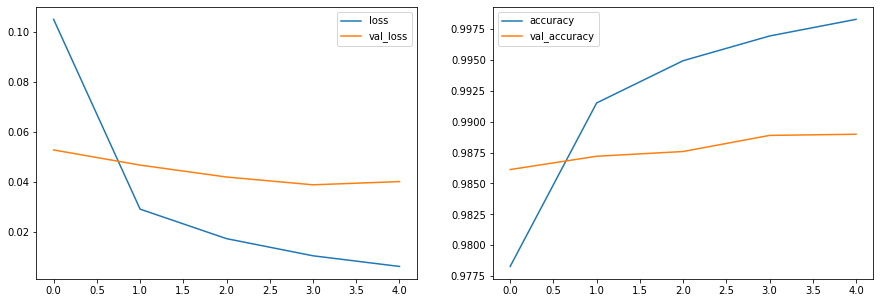

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_history(history):
    _, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5))
    history[['loss', 'val_loss']].plot.line(ax=ax1)
    history[['accuracy', 'val_accuracy']].plot.line(ax=ax2)

plot_history(history)

## Evaluation

To evaluate the performance of our model, we apply it to our validation data.

For each sample and each token, we 

- obtain a probability distribution on the schema (see `y_probs`),
- take the tag with maximal probability as the prediction (see `y_pred`),
- store the token, the true tag and the predicted tag (see `pred_samples`).


In [19]:
def predict(model):
    y_probs = model.predict(X_val)
    y_pred = np.argmax(y_probs, axis=-1)
    pred_samples = [
        [(token, tag, schema[index]) for (token, tag), index in zip(sentence, tag_pred)]
        for sentence, tag_pred in zip(val_samples, y_pred)
    ]
    return pred_samples

pred_samples = predict(model)


Let's see what the predictions look like:

In [20]:
pd.DataFrame.from_records(pred_samples[8][:30], columns=['Token', 'Truth', 'Prediction'])

Token Truth Prediction
0           Trotz     O          O
1             der     O          O
2   zweifelhaften     O          O
3       Bewertung     O          O
4             von     O          O
5            MDMA     O          O
6             als     O          O
7               "     O          O
8           harte     O          O
9           Droge     O          O
10              "     O          O
11              (     O          O
12           vgl.     O          O
13            BGH    RS         RS
14              ,    RS         RS
15      Beschluss    RS         RS
16            vom    RS         RS
17             3.    RS         RS
18        Februar    RS         RS
19           1999    RS         RS
20              -    RS         RS
21              5    RS         RS
22            StR    RS         RS
23         705/98    RS         RS
24              ,    RS         RS
25          juris    RS         RS
26            Rn.    RS         RS
27              2    RS         RS
28              ;     O          O
29            zum     O        LIT

To **evaluate** our model, we consider 

- for each tag
- the one-vs-all binary classification problem 
- of marking every token by this one tag or any other, 


and look at the *recall*, *precision* and *f1-score* of this binary classification problem.

All this is already implemented in scikit-learn:

In [21]:
from sklearn.metrics import classification_report

def evaluate(pred_samples):
    y_t = [pos[1] for sentence in pred_samples for pos in sentence]
    y_p = [pos[2]for sentence in pred_samples for pos in sentence]
    report = classification_report(y_t, y_p, output_dict=True)
    return pd.DataFrame.from_dict(report).transpose().reset_index()

scores = evaluate(pred_samples)
print(scores)


/home/thomas/data/portfolio/2020/ua9-20201120/.venv/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/thomas/data/portfolio/2020/ua9-20201120/.venv/lib64/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


           index  precision    recall  f1-score        support
0             AN   0.000000  0.000000  0.000000      52.000000
1            EUN   0.736402  0.442211  0.552590     398.000000
2            GRT   0.928826  0.405910  0.564935     643.000000
3             GS   0.963055  0.912017  0.936841    6774.000000
4            INN   0.909091  0.252101  0.394737     119.000000
5             LD   0.623932  0.848837  0.719212      86.000000
6            LDS   0.000000  0.000000  0.000000       9.000000
7            LIT   0.649092  0.893516  0.751940    1681.000000
8            MRK   0.000000  0.000000  0.000000      49.000000
9              O   0.981699  0.994184  0.987902  133429.000000
10           ORG   0.350515  0.213836  0.265625     159.000000
11           PER   0.250000  0.002114  0.004193     473.000000
12            RR   0.906404  0.657143  0.761905     560.000000
13            RS   0.956298  0.840811  0.894844    8380.000000
14            ST   0.696970  0.582278  0.634483      79

Let's also plot the scores:

In [22]:
import altair as alt

def plot(scores):
    base =  alt.Chart(scores[:-4]).encode(x=alt.X('support', scale=alt.Scale(type='log')), y='f1-score',
                                          tooltip=['index', 'support', 'recall', 'precision', 'f1-score'])
    return base.mark_point().encode(color='index') + base.mark_text().encode(text='index')

plot(scores)

alt.LayerChart(...)